# Early Fire Detection with Pytorch Faster R-CNN

## Clone the Repository

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
%cd /content/drive/MyDrive/Faster-RCNN

/content/drive/MyDrive/Faster-RCNN


In [5]:
!git clone https://github.com/sovit-123/fastercnn-pytorch-training-pipeline.git

fatal: destination path 'fastercnn-pytorch-training-pipeline' already exists and is not an empty directory.


In [6]:
# Enter the repo directory.
%cd fastercnn-pytorch-training-pipeline/

/content/drive/MyDrive/Faster-RCNN/fastercnn-pytorch-training-pipeline


In [7]:
# Install the Requirements
!pip install -r requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 23.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 69.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 952.4/952.4 kB 66.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 54.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 87.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.9/121.9 kB 17.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 kB 25.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 205.1/205.1 kB 17.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.9/84.9 kB 10.3 MB/s eta 0:00:00
  Created wheel for pathtools: filename=pathtools-0.1.2-p

## Download the Dataset

Here we are using the [Aquarium Dataset](https://public.roboflow.com/object-detection/aquarium) from Roboflow.

Download the unzip the dataset to `custom_data` directory.

In [4]:
!curl -L "https://app.roboflow.com/ds/SBRZXuY8Mh?key=LxNuycS98M" > roboflow.zip; unzip roboflow.zip -d custom_data; rm roboflow.zip


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   891  100   891    0     0   3051      0 --:--:-- --:--:-- --:--:--  3051
100 72.2M  100 72.2M    0     0  45.1M      0  0:00:01  0:00:01 --:--:-- 65.4M
Archive:  roboflow.zip
 extracting: custom_data/README.dataset.txt  
 extracting: custom_data/README.roboflow.txt  
   creating: custom_data/test/
 extracting: custom_data/test/WEB03744_jpg.rf.5f8e5635209451e1a21f424e9585c535.jpg  
 extracting: custom_data/test/WEB03744_jpg.rf.5f8e5635209451e1a21f424e9585c535.xml  
 extracting: custom_data/test/WEB03746_jpg.rf.262dfcf9fd0e814143f2be489ae5b597.jpg  
 extracting: custom_data/test/WEB03746_jpg.rf.262dfcf9fd0e814143f2be489ae5b597.xml  
 extracting: custom_data/test/WEB03747_jpg.rf.85157eacc81de8d79da14316b7cd2ee4.jpg  
 extracting: custom_data/test/WEB03747_jpg.rf.85157eacc81de8d79da14316b7cd2ee4.xml  
 extracting: custom_data/te

## Data Augmentation

In [5]:
%cd /content/drive/MyDrive/Faster-RCNN/fastercnn-pytorch-training-pipeline

/content/drive/MyDrive/Faster-RCNN/fastercnn-pytorch-training-pipeline


In [3]:
# (Image Agumentation) 
# Applies Blur, MedianBlur and ToGray albumentations in addition to the YOLOv5 hyperparameter augmentations
%%writefile datasets.py
import torch
import cv2
import numpy as np
import os
import glob as glob
import random

import torchvision.transforms as transforms

import torchvision
import time
import albumentations as A


from xml.etree import ElementTree as et
from torch.utils.data import Dataset, DataLoader
from utils.transforms import (
    get_train_transform, 
    get_valid_transform,
    get_train_aug,
    transform_mosaic
)

# define pytorch transforms
transform = transforms.Compose([
     transforms.ToPILImage(),
     transforms.Resize((300, 300)),
     transforms.CenterCrop((100, 100)),
     transforms.RandomCrop((80, 80)),
     transforms.RandomHorizontalFlip(p=0.5),
     transforms.RandomRotation(degrees=(-45, 45)),
     transforms.RandomVerticalFlip(p=0.5),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
     ])


# the dataset class
class CustomDataset(Dataset):
    def __init__(
        self, 
        images_path, 
        labels_path, 
        img_size, 
        classes, 
        transforms=None, 
        use_train_aug=False,
        train=False, 
        no_mosaic=False,
        square_training=False
    ):
        self.transforms = transforms
        self.use_train_aug = use_train_aug
        self.images_path = images_path
        self.labels_path = labels_path
        self.img_size = img_size
        self.classes = classes
        self.train = train
        self.no_mosaic = no_mosaic
        self.square_training = square_training
        self.mosaic_border = [-img_size // 2, -img_size // 2]
        self.image_file_types = ['*.jpg', '*.jpeg', '*.png', '*.ppm', '*.JPG']
        self.all_image_paths = []
        self.log_annot_issue_x = True
        self.log_annot_issue_y = True
        
        # get all the image paths in sorted order
        for file_type in self.image_file_types:
            self.all_image_paths.extend(glob.glob(os.path.join(self.images_path, file_type)))
        self.all_annot_paths = glob.glob(os.path.join(self.labels_path, '*.xml'))
        self.all_images = [image_path.split(os.path.sep)[-1] for image_path in self.all_image_paths]
        self.all_images = sorted(self.all_images)
        # Remove all annotations and images when no object is present.
        self.read_and_clean()

    def read_and_clean(self):
        # Discard any images and labels when the XML 
        # file does not contain any object.
        for annot_path in self.all_annot_paths:
            tree = et.parse(annot_path)
            root = tree.getroot()
            object_present = False
            for member in root.findall('object'):
                if member.find('bndbox'):
                    object_present = True
            if object_present == False:
                image_name = annot_path.split(os.path.sep)[-1].split('.xml')[0]
                image_root = self.all_image_paths[0].split(os.path.sep)[:-1]

        # Discard any image file when no annotation file 
        # is not found for the image. 
        for image_name in self.all_images:
            possible_xml_name = os.path.join(self.labels_path, os.path.splitext(image_name)[0]+'.xml')
            if possible_xml_name not in self.all_annot_paths:
                print(f"{possible_xml_name} not found...")
                print(f"Removing {image_name} image")
                self.all_images = [image_instance for image_instance in self.all_images if image_instance != image_name]

    def resize(self, im, square=False):
        if square:
            im = cv2.resize(im, (self.img_size, self.img_size))
        else:
            h0, w0 = im.shape[:2]  # orig hw
            r = self.img_size / max(h0, w0)  # ratio
            if r != 1:  # if sizes are not equal
                im = cv2.resize(im, (int(w0 * r), int(h0 * r)))
        return im

    def load_image_and_labels(self, index):
        image_name = self.all_images[index]
        image_path = os.path.join(self.images_path, image_name)

        # Read the image.
        image = cv2.imread(image_path)
        # Convert BGR to RGB color format.
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image_resized = self.resize(image, square=self.square_training)
        image_resized /= 255.0
        
        # Capture the corresponding XML file for getting the annotations.
        annot_filename = os.path.splitext(image_name)[0] + '.xml'
        annot_file_path = os.path.join(self.labels_path, annot_filename)

        boxes = []
        orig_boxes = []
        labels = []
        tree = et.parse(annot_file_path)
        root = tree.getroot()
        
        # Get the height and width of the image.
        image_width = image.shape[1]
        image_height = image.shape[0]
                
        # Box coordinates for xml files are extracted and corrected for image size given.
        for member in root.findall('object'):
            # Map the current object name to `classes` list to get
            # the label index and append to `labels` list.
            labels.append(self.classes.index(member.find('name').text))
            
            # xmin = left corner x-coordinates
            xmin = float(member.find('bndbox').find('xmin').text)
            # xmax = right corner x-coordinates
            xmax = float(member.find('bndbox').find('xmax').text)
            # ymin = left corner y-coordinates
            ymin = float(member.find('bndbox').find('ymin').text)
            # ymax = right corner y-coordinates
            ymax = float(member.find('bndbox').find('ymax').text)

            xmin, ymin, xmax, ymax = self.check_image_and_annotation(
                xmin, 
                ymin, 
                xmax, 
                ymax, 
                image_width, 
                image_height, 
                orig_data=True
            )

            orig_boxes.append([xmin, ymin, xmax, ymax])
            
            # Resize the bounding boxes according to the
            # desired `width`, `height`.
            xmin_final = (xmin/image_width)*image_resized.shape[1]
            xmax_final = (xmax/image_width)*image_resized.shape[1]
            ymin_final = (ymin/image_height)*image_resized.shape[0]
            ymax_final = (ymax/image_height)*image_resized.shape[0]

            xmin_final, ymin_final, xmax_final, ymax_final = self.check_image_and_annotation(
                xmin_final, 
                ymin_final, 
                xmax_final, 
                ymax_final, 
                image_resized.shape[1], 
                image_resized.shape[0],
                orig_data=False
            )
            
            boxes.append([xmin_final, ymin_final, xmax_final, ymax_final])
        
        # Bounding box to tensor.
        boxes_length = len(boxes)
        boxes = torch.as_tensor(boxes, dtype=torch.float32)

        # Area of the bounding boxes.

        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0]) if boxes_length > 0 else torch.as_tensor(boxes, dtype=torch.float32)
        # No crowd instances.
        iscrowd = torch.zeros((boxes.shape[0],), dtype=torch.int64) if boxes_length > 0 else torch.as_tensor(boxes, dtype=torch.float32)
        # Labels to tensor.
        labels = torch.as_tensor(labels, dtype=torch.int64)
        return image, image_resized, orig_boxes, \
            boxes, labels, area, iscrowd, (image_width, image_height)

    def check_image_and_annotation(
        self, 
        xmin, 
        ymin, 
        xmax, 
        ymax, 
        width, 
        height, 
        orig_data=False
    ):
        """
        Check that all x_max and y_max are not more than the image
        width or height.
        """
        if ymax > height:
            ymax = height
        if xmax > width:
            xmax = width
        if xmax - xmin <= 1.0:
            if orig_data:
                # print(
                    # '\n',
                    # '!!! xmax is equal to xmin in data annotations !!!'
                    # 'Please check data'
                # )
                # print(
                    # 'Increasing xmax by 1 pixel to continue training for now...',
                    # 'THIS WILL ONLY BE LOGGED ONCE',
                    # '\n'
                # )
                self.log_annot_issue_x = False
            xmin = xmin - 1
        if ymax - ymin <= 1.0:
            if orig_data:
                # print(
                #     '\n',
                #     '!!! ymax is equal to ymin in data annotations !!!',
                #     'Please check data'
                # )
                # print(
                #     'Increasing ymax by 1 pixel to continue training for now...',
                #     'THIS WILL ONLY BE LOGGED ONCE',
                #     '\n'
                # )
                self.log_annot_issue_y = False
            ymin = ymin - 1
        return xmin, ymin, xmax, ymax


    def load_cutmix_image_and_boxes(self, index, resize_factor=512):
        """ 
        Adapted from: https://www.kaggle.com/shonenkov/oof-evaluation-mixup-efficientdet
        """
        s = self.img_size
        yc, xc = (int(random.uniform(-x, 2 * s + x)) for x in self.mosaic_border)  # mosaic center x, y
        indices = [index] + [random.randint(0, len(self.all_images) - 1) for _ in range(3)]

        # Create empty image with the above resized image.
        # result_image = np.full((h, w, 3), 1, dtype=np.float32)
        result_boxes = []
        result_classes = []

        for i, index in enumerate(indices):
            _, image_resized, orig_boxes, boxes, \
            labels, area, iscrowd, dims = self.load_image_and_labels(
                index=index
            )

            h, w = image_resized.shape[:2]

            if i == 0:
                # Create empty image with the above resized image.
                result_image = np.full((s * 2, s * 2, image_resized.shape[2]), 114/255, dtype=np.float32)  # base image with 4 tiles
                x1a, y1a, x2a, y2a = max(xc - w, 0), max(yc - h, 0), xc, yc  # xmin, ymin, xmax, ymax (large image)
                x1b, y1b, x2b, y2b = w - (x2a - x1a), h - (y2a - y1a), w, h  # xmin, ymin, xmax, ymax (small image)
            elif i == 1:  # top right
                x1a, y1a, x2a, y2a = xc, max(yc - h, 0), min(xc + w, s * 2), yc
                x1b, y1b, x2b, y2b = 0, h - (y2a - y1a), min(w, x2a - x1a), h
            elif i == 2:  # bottom left
                x1a, y1a, x2a, y2a = max(xc - w, 0), yc, xc, min(s * 2, yc + h)
                x1b, y1b, x2b, y2b = w - (x2a - x1a), 0, max(xc, w), min(y2a - y1a, h)
            elif i == 3:  # bottom right
                x1a, y1a, x2a, y2a = xc, yc, min(xc + w, s * 2), min(s * 2, yc + h)
                x1b, y1b, x2b, y2b = 0, 0, min(w, x2a - x1a), min(y2a - y1a, h)
            result_image[y1a:y2a, x1a:x2a] = image_resized[y1b:y2b, x1b:x2b]
            padw = x1a - x1b
            padh = y1a - y1b

            if len(orig_boxes) > 0:
                boxes[:, 0] += padw
                boxes[:, 1] += padh
                boxes[:, 2] += padw
                boxes[:, 3] += padh

                result_boxes.append(boxes)
                result_classes += labels

        final_classes = []
        if len(result_boxes) > 0:
            result_boxes = np.concatenate(result_boxes, 0)
            np.clip(result_boxes[:, 0:], 0, 2 * s, out=result_boxes[:, 0:])
            result_boxes = result_boxes.astype(np.int32)
            for idx in range(len(result_boxes)):
                if ((result_boxes[idx, 2] - result_boxes[idx, 0]) * (result_boxes[idx, 3] - result_boxes[idx, 1])) > 0:
                    final_classes.append(result_classes[idx])
            result_boxes = result_boxes[
                np.where((result_boxes[:, 2] - result_boxes[:, 0]) * (result_boxes[:, 3] - result_boxes[:, 1]) > 0)
            ]
        # Resize the mosaic image to the desired shape and transform boxes.
        result_image, result_boxes = transform_mosaic(
            result_image, result_boxes, self.img_size
        )
        return result_image, torch.tensor(result_boxes), \
            torch.tensor(np.array(final_classes)), area, iscrowd, dims

    def __getitem__(self, idx):
        # Capture the image name and the full image path.
        if self.no_mosaic:
            image, image_resized, orig_boxes, boxes, \
                labels, area, iscrowd, dims = self.load_image_and_labels(
                index=idx
            )

        if self.train and not self.no_mosaic:
            #while True:
            image_resized, boxes, labels, \
                area, iscrowd, dims = self.load_cutmix_image_and_boxes(
                idx, resize_factor=(self.img_size, self.img_size)
            )
                # Only needed if we don't allow training without target bounding boxes
               # if len(boxes) > 0:
               #     break
        
        # visualize_mosaic_images(boxes, labels, image_resized, self.classes)

        # Prepare the final `target` dictionary.
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["area"] = area
        target["iscrowd"] = iscrowd
        image_id = torch.tensor([idx])
        target["image_id"] = image_id


        if self.use_train_aug: # Use train augmentation if argument is passed.
            train_aug = get_train_aug()
            sample = train_aug(image=image_resized,
                                     bboxes=target['boxes'],
                                     labels=labels)
            image_resized = sample['image']
            target['boxes'] = torch.Tensor(sample['bboxes']).to(torch.int64)
        else:
            sample = self.transforms(image=image_resized,
                                     bboxes=target['boxes'],
                                     labels=labels)
            image_resized = sample['image']
            target['boxes'] = torch.Tensor(sample['bboxes']).to(torch.int64)

        # Fix to enable training without target bounding boxes,
        # see https://discuss.pytorch.org/t/fasterrcnn-images-with-no-objects-present-cause-an-error/117974/4
        if np.isnan((target['boxes']).numpy()).any() or target['boxes'].shape == torch.Size([0]):
            target['boxes'] = torch.zeros((0, 4), dtype=torch.int64)
        return image_resized, target

    def __len__(self):
        return len(self.all_images)

def collate_fn(batch):
    """
    To handle the data loading as different images may have different number 
    of objects and to handle varying size tensors as well.
    """
    return tuple(zip(*batch))

# Prepare the final datasets and data loaders.
def create_train_dataset(
    train_dir_images, 
    train_dir_labels, 
    img_size, 
    classes,
    use_train_aug=False,
    no_mosaic=False,
    square_training=False
):
    train_dataset = CustomDataset(
        train_dir_images, 
        train_dir_labels,
        img_size, 
        classes, 
        get_train_transform(),
        use_train_aug=use_train_aug,
        train=True, 
        no_mosaic=no_mosaic,
        square_training=square_training
    )
    return train_dataset
def create_valid_dataset(
    valid_dir_images, 
    valid_dir_labels, 
    img_size, 
    classes,
    square_training=False
):
    valid_dataset = CustomDataset(
        valid_dir_images, 
        valid_dir_labels, 
        img_size, 
        classes, 
        get_valid_transform(),
        train=False, 
        no_mosaic=True,
        square_training=square_training
    )
    return valid_dataset

def create_train_loader(
    train_dataset, batch_size, num_workers=0, batch_sampler=None
):
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        # shuffle=True,
        num_workers=num_workers,
        collate_fn=collate_fn,
        sampler=batch_sampler
    )
    return train_loader

def create_valid_loader(
    valid_dataset, batch_size, num_workers=0, batch_sampler=None
):
    valid_loader = DataLoader(
        valid_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        collate_fn=collate_fn,
        sampler=batch_sampler
    )
    return valid_loader

Overwriting datasets.py


In [9]:
# imports
import torch
import torchvision.transforms as transforms
import glob
import matplotlib.pyplot as plt
import numpy as np
import torchvision
import time
import albumentations as A
from torch.utils.data import DataLoader, Dataset
from PIL import Image

In [11]:
%cd /content/drive/MyDrive/Faster-RCNN/fastercnn-pytorch-training-pipeline/custom_data/
valid_image_list = glob.glob('valid/*.jpg')
print(len(valid_image_list))

/content/drive/MyDrive/Faster-RCNN/fastercnn-pytorch-training-pipeline/custom_data
200


In [13]:
# define pytorch transforms
transform = transforms.Compose([
     transforms.ToPILImage(),
     transforms.Resize((300, 300)),
     transforms.CenterCrop((100, 100)),
     transforms.RandomCrop((80, 80)),
     transforms.RandomHorizontalFlip(p=0.5),
     transforms.RandomRotation(degrees=(-45, 45)),
     transforms.RandomVerticalFlip(p=0.5),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
     ])

In [14]:
# PyTorch image augmentation module
class PyTorchImageDataset(Dataset):
    def __init__(self, image_list, transforms=None):
        self.image_list = image_list
        self.transforms = transforms
         
    def __len__(self):
        return (len(self.image_list))
    
    def __getitem__(self, i):
        image = plt.imread(self.image_list[i])
        image = Image.fromarray(image).convert('RGB')        
        image = np.asarray(image).astype(np.uint8)
        if self.transforms is not None:
            image = self.transforms(image)
            
        return torch.tensor(image, dtype=torch.float)


In [15]:
pytorch_dataset = PyTorchImageDataset(image_list=valid_image_list, transforms=transform)
pytorch_dataloader = DataLoader(dataset=pytorch_dataset, batch_size=16, shuffle=True)

In [16]:
#show image after augmentation 
def show_img(img):
    plt.figure(figsize=(18,15))
    # unnormalize
    img = img / 2 + 0.5  
    npimg = img.numpy()
    npimg = np.clip(npimg, 0., 1.)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

<ipython-input-14-dfc5497ab8da>:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(image, dtype=torch.float)


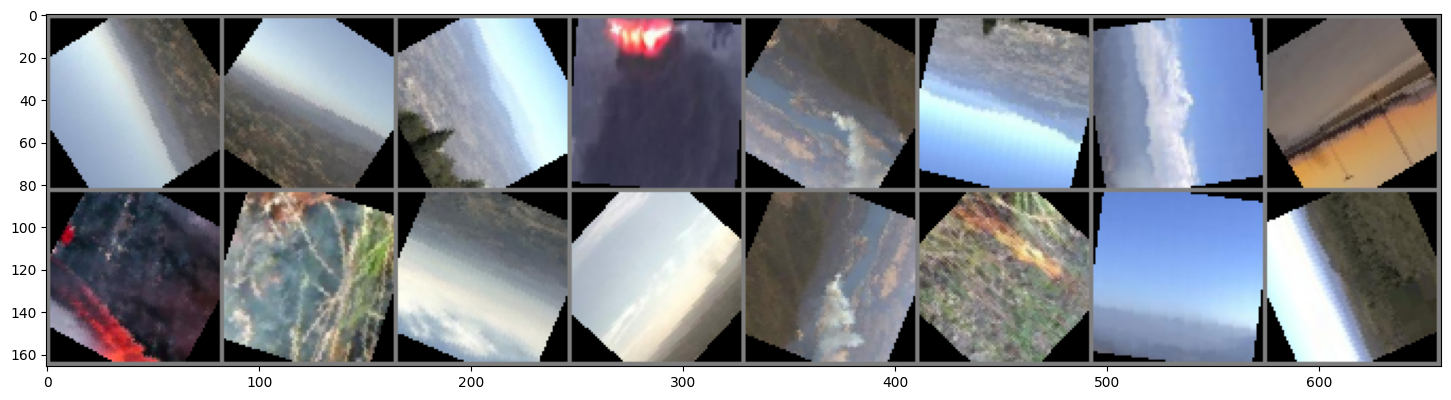

In [17]:
data = iter(pytorch_dataloader)
images = next(data)
# show images
show_img(torchvision.utils.make_grid(images))

## Create the Custom Dataset YAML File.

In [6]:
%%writefile data_configs/custom_data.yaml
# Images and labels direcotry should be relative to train.py
TRAIN_DIR_IMAGES: 'custom_data/train'
TRAIN_DIR_LABELS: 'custom_data/train'
VALID_DIR_IMAGES: 'custom_data/valid'
VALID_DIR_LABELS: 'custom_data/valid'

# Class names.
CLASSES: [
    '__background__',
    '1', '0'
]

# Number of classes (object classes + 1 for background class in Faster RCNN).
NC: 3

# Whether to save the predictions of the validation set while training.
SAVE_VALID_PREDICTION_IMAGES: True

Overwriting data_configs/custom_data.yaml


## Train with ResNet50_FPN backbone

In [1]:
!pip install vision_transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for vision_transformers: filename=vision_transformers-0.1.1.0-py3-none-any.whl size=48431 sha256=6fb79e2362e01f50e16c45f6e56c6ed4c3da801a2cc4ca1b2cf4543bbdfaff15
  Stored in directory: /root/.cache/pip/wheels/02/f4/94/0a5c8d2a4fcb6aa4c590906ffd3d52dc8edbe94262ecaa7dae
Successfully built vision_transformers


In [2]:
!pip install tensorrt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for tensorrt: filename=tensorrt-8.6.1-py2.py3-none-any.whl size=16984 sha256=2a2f2cce36c946dd8bb998ab2d48e19e42eac685597f9bf71d8819f17e101170
  Stored in directory: /root/.cache/pip/wheels/6d/29/56/abdffd4c604f255b5254bef3f1c598ab7811ea020540599438
Successfully built tensorrt


In [13]:
!python train.py --data data_configs/custom_data.yaml -e 50 -m fasterrcnn_resnet50_fpn -n custom_training3 -b 16 

2023-05-15 20:46:25.134998: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-15 20:46:26.166495: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Not using distributed mode
wandb: Currently logged in as: angelaqu129 (angela-qu). Use `wandb login --relogin` to force relogin
wandb: Tracking run with wandb version 0.15.2
wandb: Run data is saved locally in /content/drive/MyDrive/Faster-RCNN/fastercnn-pytorch-training-pipeline/wandb/run-20230515_204629-wcyp3o66
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run custom_training3
wandb: ⭐️ View project at https://wandb.ai/angela-qu/fastercnn-pytorch-training-pipeline
wandb: 🚀 View run at https://wandb.ai/angela-qu/fastercnn-pytorch-training-

### Inference
### Image Inference in Custom Trained Model

In [14]:
%cd /content/drive/MyDrive/Faster-RCNN/fastercnn-pytorch-training-pipeline/
! python inference.py -m fasterrcnn_resnet50_fpn --input example_test_data/images --weights outputs/training/custom_training3/last_model_state.pth

/content/drive/MyDrive/Faster-RCNN/fastercnn-pytorch-training-pipeline
Building from model name arguments...
Test instances: 200
Image 1 done...
--------------------------------------------------
Image 2 done...
--------------------------------------------------
Image 3 done...
--------------------------------------------------
Image 4 done...
--------------------------------------------------
Image 5 done...
--------------------------------------------------
Image 6 done...
--------------------------------------------------
Image 7 done...
--------------------------------------------------
Image 8 done...
--------------------------------------------------
Image 9 done...
--------------------------------------------------
Image 10 done...
--------------------------------------------------
Image 11 done...
--------------------------------------------------
Image 12 done...
--------------------------------------------------
Image 13 done...
-----------------------------------------------

### Evaluation 

In [15]:
! python eval.py --model fasterrcnn_resnet50_fpn --weights outputs/training/custom_training3/best_model.pth --data data_configs/custom_data.yaml --batch 16 --verbose

2023-05-15 22:41:31.067409: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-15 22:41:33.094999: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100% 13/13 [00:12<00:00,  1.08it/s]


{'map': tensor(0.2026),
 'map_50': tensor(0.4886),


## Train with EfficientNet_b0 backbone

In [27]:
!python train.py --data data_configs/custom_data.yaml -e 20 -m fasterrcnn_efficientnet_b0 -n custom_training4 -b 8

2023-05-16 01:40:30.889748: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-16 01:40:31.883616: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Not using distributed mode
wandb: Currently logged in as: angelaqu129 (angela-qu). Use `wandb login --relogin` to force relogin
wandb: Tracking run with wandb version 0.15.2
wandb: Run data is saved locally in /content/drive/MyDrive/Faster-RCNN/fastercnn-pytorch-training-pipeline/wandb/run-20230516_014035-3tph0ba6
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run custom_training4
wandb: ⭐️ View project at https://wandb.ai/angela-qu/fastercnn-pytorch-training-pipeline
wandb: 🚀 View run at https://wandb.ai/angela-qu/fastercnn-pytorch-training-

### Evaluation

In [28]:
! python eval.py --model fasterrcnn_efficientnet_b0 --weights outputs/training/custom_training4/best_model.pth --data data_configs/custom_data.yaml --batch 8 --verbose

2023-05-16 01:41:46.791815: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-16 01:41:48.360733: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100% 25/25 [00:19<00:00,  1.28it/s]


{'map': tensor(0.0718),
 'map_50': tensor(0.2138),
